In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data.csv")
data = data[data['species_name'] == "Rusa alfredi (Visayan Spotted Deer)"]
data=data[['date_report','no_observation']]
data.head()

,date_report,no_observation
6,2016-01-18,21
11,2016-02-15,19
14,2016-02-15,21
19,2016-03-14,20
22,2016-03-14,14


In [3]:
data.index = pd.to_datetime(data['date_report'])
data.drop(columns='date_report',inplace=True)
data.head()
data = data.resample('M').sum()
data

,no_observation
date_report,
2016-01-31,21
2016-02-29,40
2016-03-31,34
2016-04-30,43
2016-05-31,43
...,...
2021-08-31,23
2021-09-30,29
2021-10-31,41


In [4]:
data.isna().sum()

no_observation    0
dtype: int64

<AxesSubplot:xlabel='date_report'>

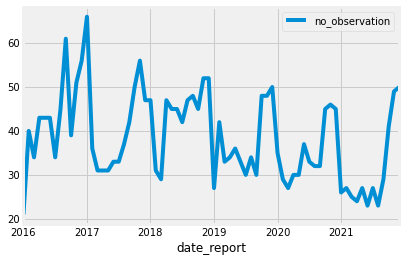

In [5]:
data.plot()

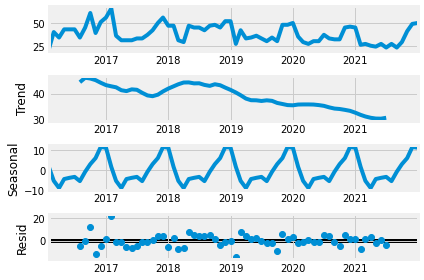

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='date_report'>

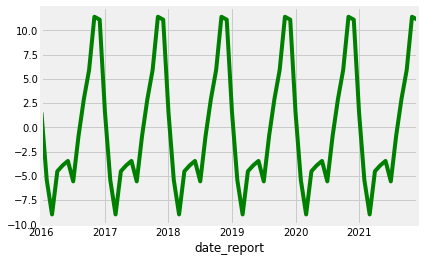

In [7]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [8]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.no_observation, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.2021879875367616
2. P-Value :  0.6726537874170677
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


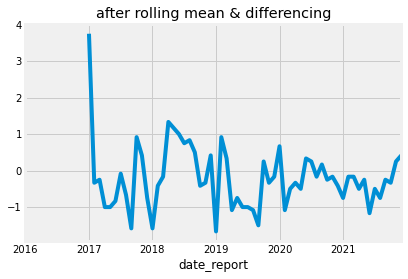

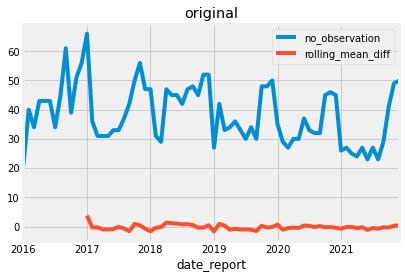

In [9]:
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [10]:
dftest = adfuller(data['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -4.5121362605434845
2. P-Value :  0.00018694573100650556
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 48
5. Critical Values :
	 1% :  -3.5745892596209488
	 5% :  -2.9239543084490744
	 10% :  -2.6000391840277777


In [11]:
from pmdarima import auto_arima

Sarimax_model = auto_arima(data.no_observation,
                       start_p=0,
                       start_q=0,
                       max_p=3,
                       max_q=3,
                       m=12,
                       test='adf',
                       seasonal=True,
                       d=1,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=452.511, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=461.659, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=446.928, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=456.715, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=442.176, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=444.083, Time=0.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=443.683, Time=0.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=451.195, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=440.358, Time=0.27 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=444.705, Time=0.12 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=442.355, Time=0.58 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=441.383, Time=0.29 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=436.116, Time=0.73 sec
 ARIMA(3,1,0)(1,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -211.379
Date:                                 Sun, 28 Nov 2021   AIC                            430.758
Time:                                         11:12:13   BIC                            439.068
Sample:                                              0   HQIC                           434.002
                                                  - 72                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8723      0.116     -7.537      0.000      -1.099      -0.645
ma.S.L12      -0.9275      0.176     -5.276      0.000      -1.272      -0.583
ma.S.L24       0.3556      0.212      1.677      0.094      -0.060       0.771
sigma2        61.2225     12.692      4.824      0.000      36.346      86.099
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):                 7.20
Prob(Q):                              0.25   Prob(JB):                         0.03
Heteroskedasticity (H):               0.25   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model=ARIMA(data['no_observation'],order=(0,1,1))
history=model.fit()

In [13]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.no_observation   No. Observations:                   71
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -256.334
Method:                       css-mle   S.D. of innovations              8.943
Date:                Sun, 28 Nov 2021   AIC                            518.668
Time:                        11:12:13   BIC                            525.456
Sample:                    02-29-2016   HQIC                           521.367
                         - 12-31-2021                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3261      0.776      0.420      0.674      -1.195       1.847
ma.L1.D.no_observation    -0.2742      0.141     -1.938      0.053      -0.551       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            3.6474           +0.0000j            3.6474            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='date_report'>

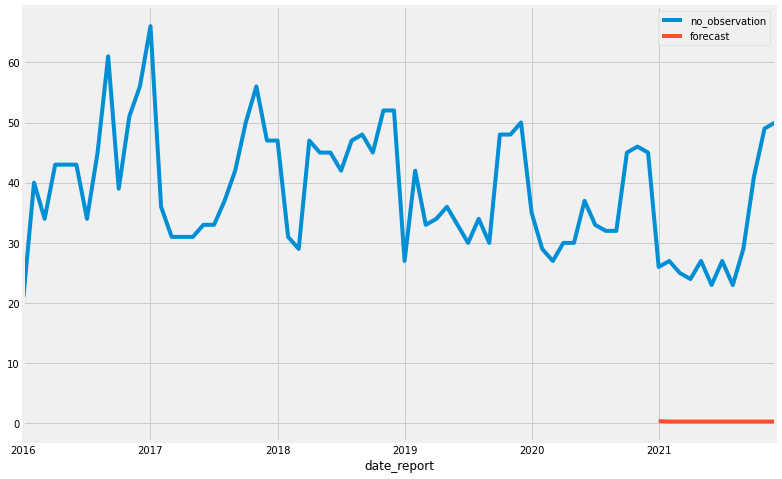

In [14]:
model_fit=model.fit()
data['forecast']=model_fit.predict(start=60,end=72,dynamic=True)
data[['no_observation','forecast']].plot(figsize=(12,8))

In [15]:
model=ARIMA(data['rolling_mean_diff'].dropna(),order=(0,1,1))
model_fit=model.fit()

<AxesSubplot:xlabel='date_report'>

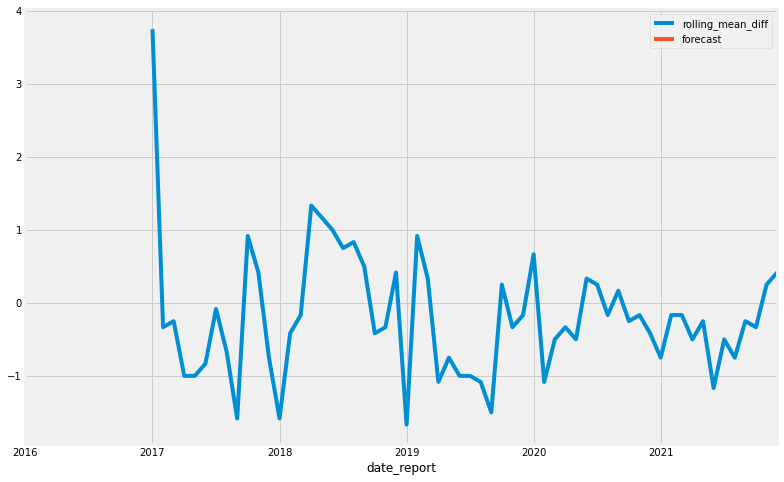

In [16]:
data['forecast']=model_fit.predict(start=60,end=72,dynamic=True)
data[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

In [17]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['no_observation'],order=(0, 1, 1),seasonal_order=(0,1,2,12))
results=model.fit()

<AxesSubplot:xlabel='date_report'>

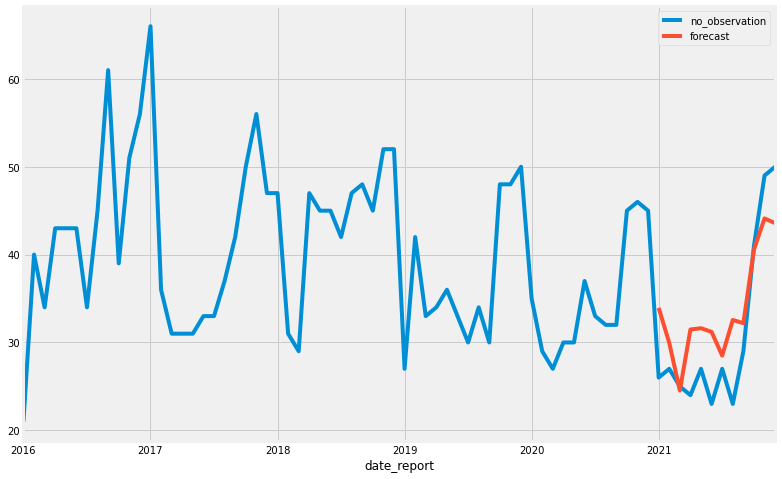

In [18]:
data['forecast']=results.predict(start=60,end=72,dynamic=True)
data[['no_observation','forecast']].plot(figsize=(12,8))

In [19]:
s_residuals = data['no_observation'] -data['forecast']

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(s_residuals/data.no_observation)),2))

Mean Absolute Percent Error: 0.17


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(s_residuals**2)))

Root Mean Squared Error: 5.668165809339257


In [22]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [23]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,no_observation,rolling_mean_diff,forecast
2022-01-31,NaN,NaN,NaN
2022-02-28,NaN,NaN,NaN
2022-03-31,NaN,NaN,NaN
2022-04-30,NaN,NaN,NaN
2022-05-31,NaN,NaN,NaN
2022-06-30,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN
2022-08-31,NaN,NaN,NaN
2022-09-30,NaN,NaN,NaN
2022-10-31,NaN,NaN,NaN


In [24]:
data=pd.concat([data,pred_date])

,no_observation,rolling_mean_diff,forecast
2016-01-31,21,NaN,NaN
2016-02-29,40,NaN,NaN
2016-03-31,34,NaN,NaN
2016-04-30,43,NaN,NaN
2016-05-31,43,NaN,NaN
...,...,...,...
2023-07-31,NaN,NaN,21.301025
2023-08-31,NaN,NaN,19.600242
2023-09-30,NaN,NaN,20.451501
2023-10-31,NaN,NaN,35.140604


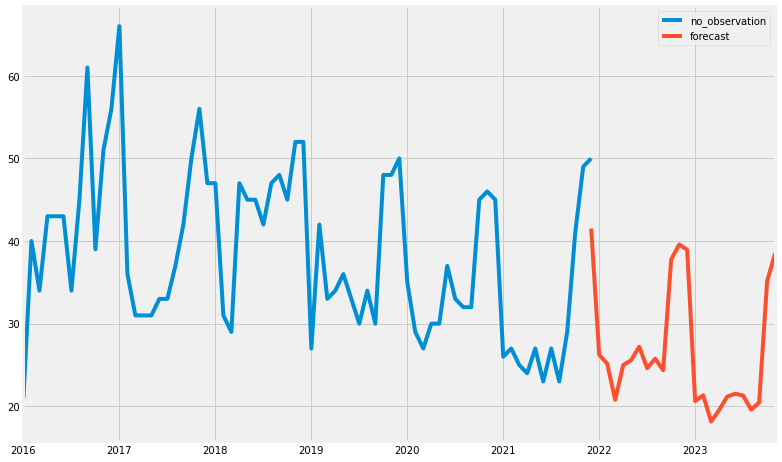

In [25]:
data['forecast'] = results.predict(start = 71, end = 96, dynamic= True)  
data[['no_observation', 'forecast']].plot(figsize=(12, 8))
data

In [26]:
data.tail(24)

,no_observation,rolling_mean_diff,forecast
2021-12-31,50,0.416667,41.512502
2022-01-31,NaN,NaN,26.229385
2022-02-28,NaN,NaN,25.163752
2022-03-31,NaN,NaN,20.775613
2022-04-30,NaN,NaN,24.985560
2022-05-31,NaN,NaN,25.591847
2022-06-30,NaN,NaN,27.210600
2022-07-31,NaN,NaN,24.616371
2022-08-31,NaN,NaN,25.768923
2022-09-30,NaN,NaN,24.366971
